# Dropsinator

In [86]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel

from scipy.signal import find_peaks
from scipy import optimize as optim

import uncertainties as unc

import sys
sys.path.append('../Library')

import drop_detection_tools as ddt


plot_dir = '../../../Report/Plots/'
plot_dir.rstrip('/')

from importlib import reload


from tqdm import tqdm
%matplotlib inline

In [87]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' :  18,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Data acquisition

../Library/drop_detection_tools.py:54: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


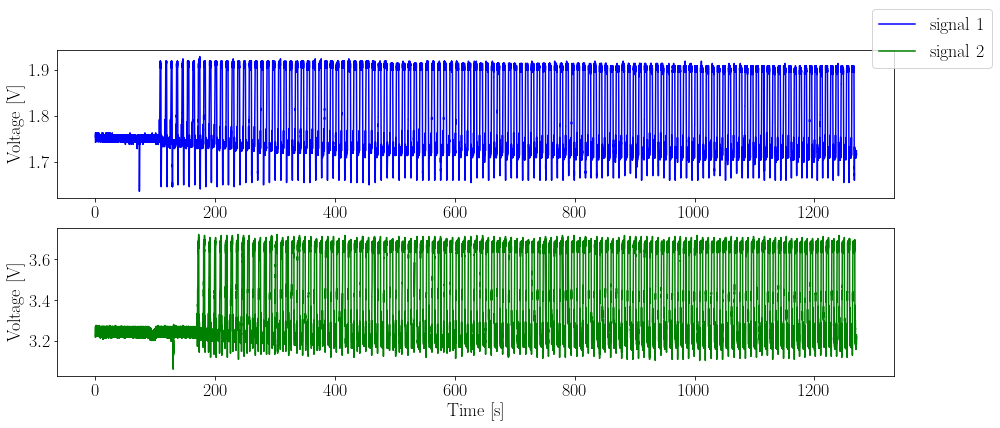

In [9]:
#************************************
folder   = '../../../T-data/2-12/'
filename = 'B-ol2-aq2-pause10.csv'
name     = '2-12_B-ol15-aq15'
#************************************

raw = True 
sig1, sig2, t_raw = ddt.read_LV(folder, filename)

## Resample data

<ipython-input-10-2c55b89d88de>:22: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


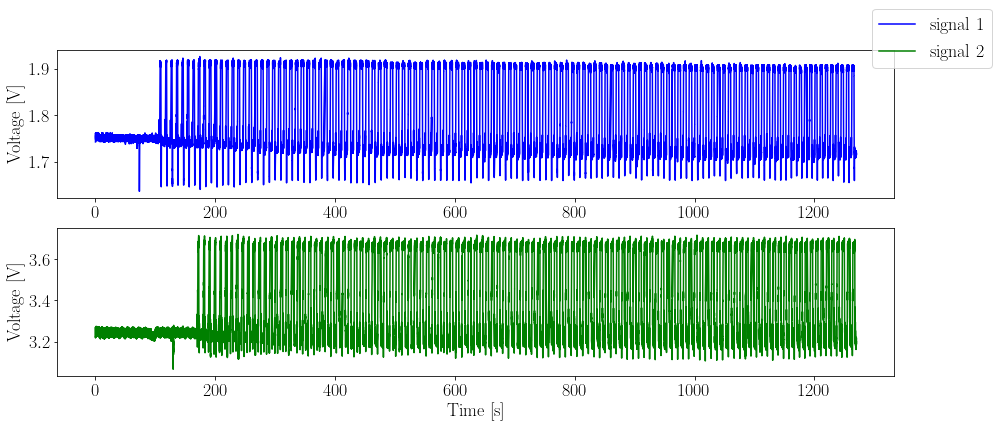

In [10]:
#******************************
dt = 0.01  # sampling time [s]
#******************************

# Resampling of the two signals
if raw:
    sig1, new_t = ddt.resample(sig1, t_raw, dt=dt)
    sig2, _     = ddt.resample(sig2, t_raw, dt=dt)
    t           = new_t
    raw         = False 
else:
    print('data already resampled')

    
# Signals plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
axs[0].plot(t, sig1, color='blue', label= "signal 1")
axs[0].set_ylabel('Voltage [V]')
axs[1].plot(t, sig2, color='green', label= "signal 2")
axs[1].set_ylabel('Voltage [V]')
axs[1].set_xlabel('Time [s]')
fig.legend(loc='best')

## Fourier transform


In [15]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 19000   # higher cut-off frequency

### Signal 1 

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library/drop_detection_tools.py:283: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


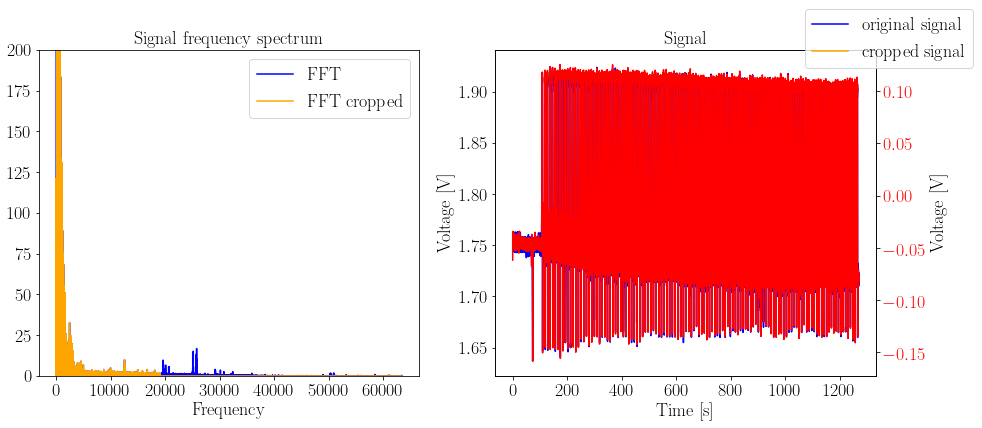

In [16]:
sig1_high = ddt.FFT_cropping(sig1, t, min_freq, max_freq)

### Signal 2 

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library/drop_detection_tools.py:283: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


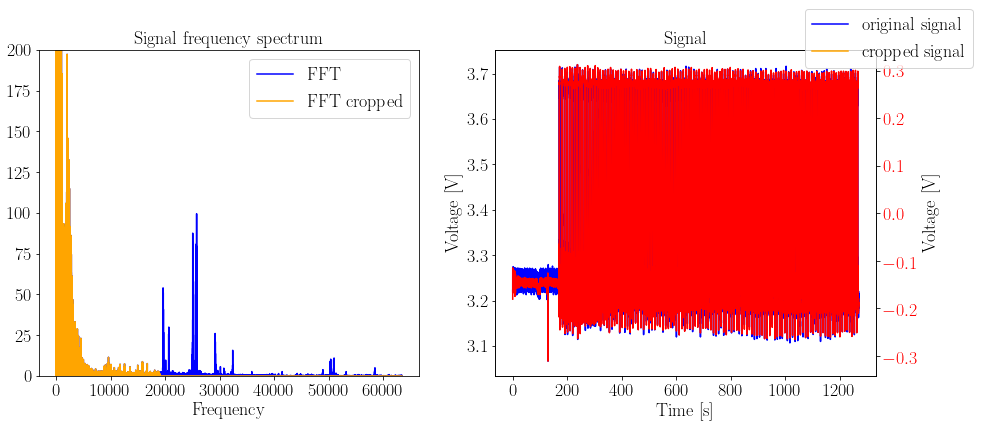

In [17]:
sig2_high = ddt.FFT_cropping(sig2, t, min_freq, max_freq)

## Signal Rectify

### Signal 1 

100%|██████████| 126992/126992 [00:34<00:00, 3704.32it/s]


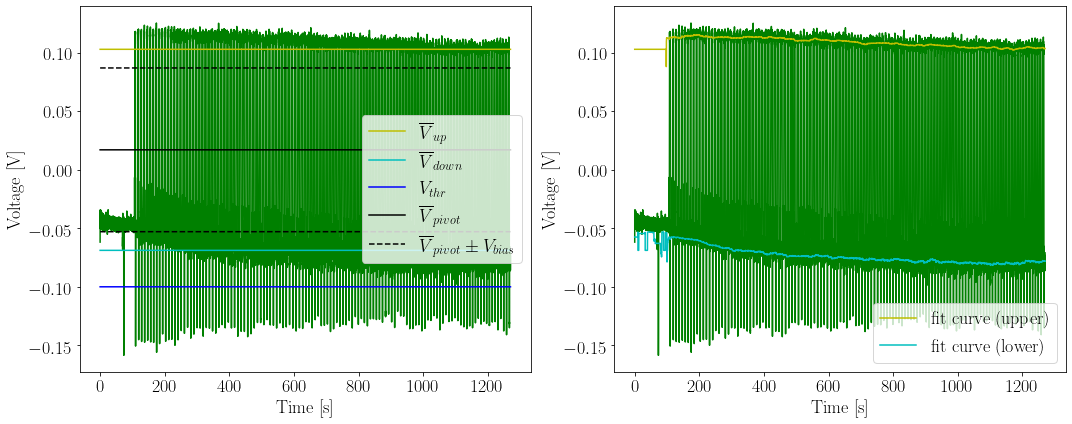

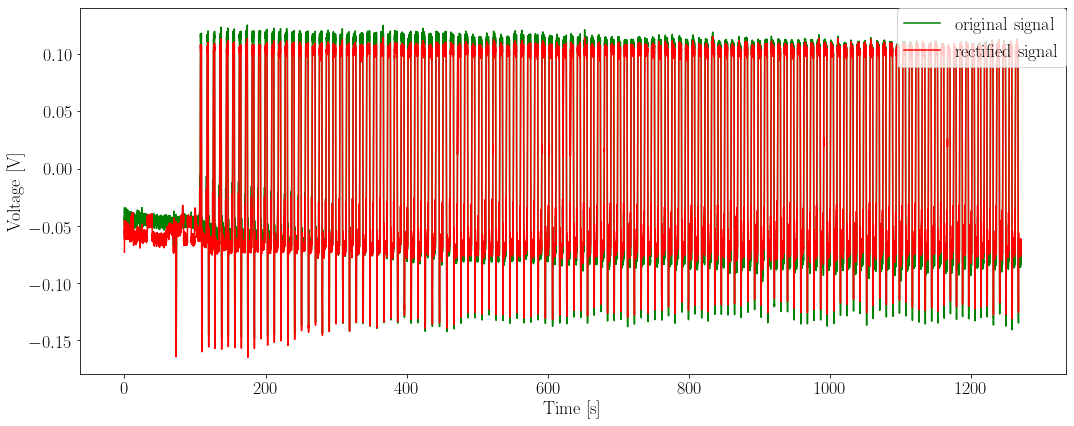

In [18]:
%matplotlib inline

fig, sig1_r = ddt.rectify_new(sig1_high, xrange=10, xdata=t, ignore_bias=0.07, manual_thr=-0.1)

### Signal 2

100%|██████████| 126992/126992 [00:34<00:00, 3681.50it/s]


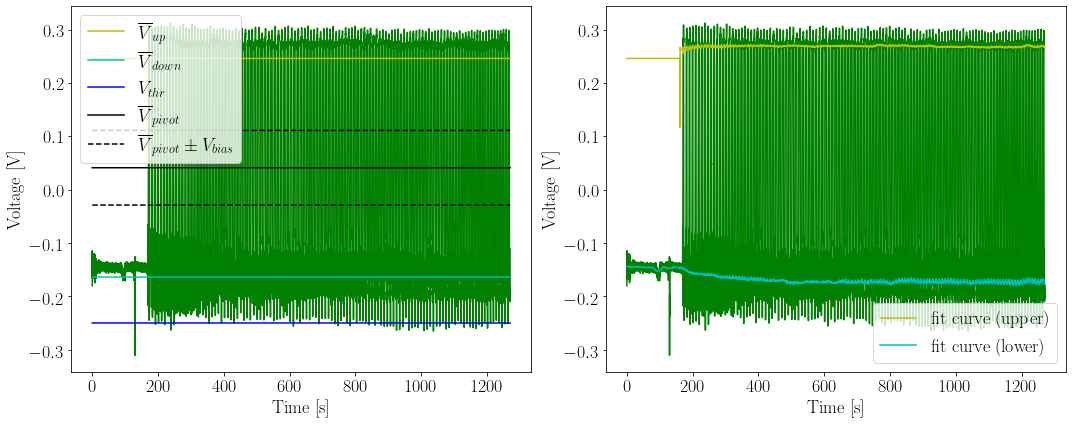

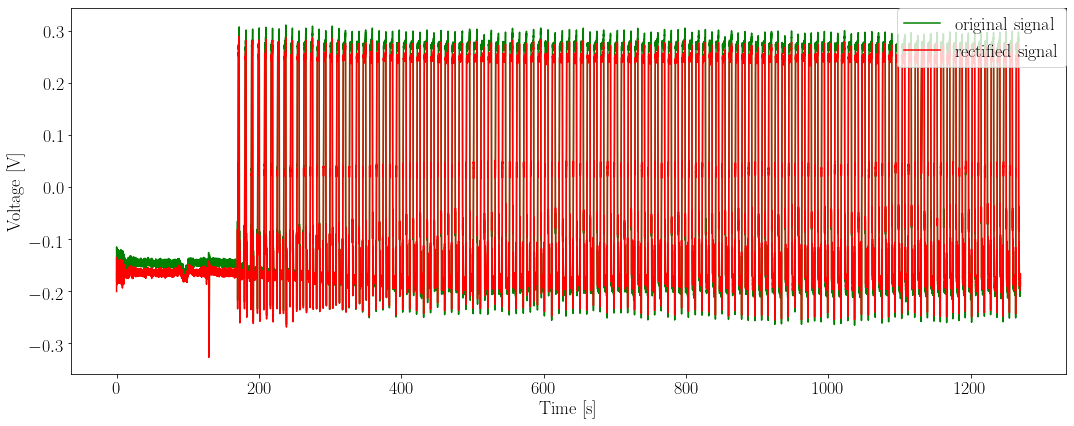

In [19]:
fig, sig2_r = ddt.rectify_new(sig2_high, xrange=10, xdata=t, ignore_bias=0.07, manual_thr=-0.25)

## Thresholds computing

### Signal 1

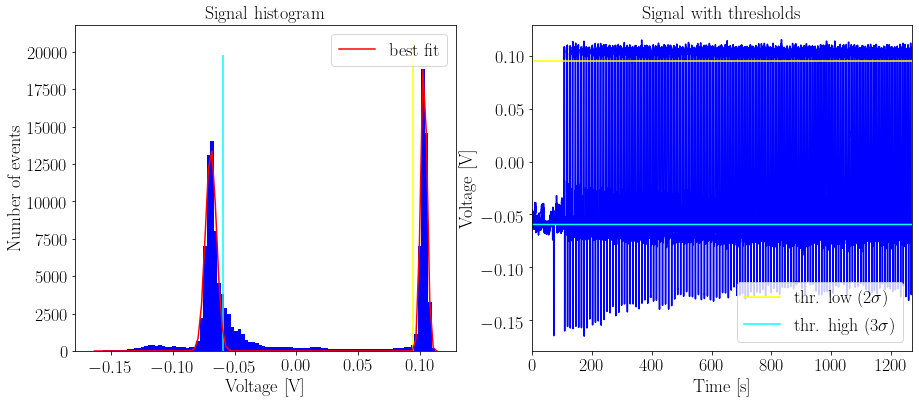

In [20]:
%matplotlib inline
thr_low_1, thr_high_1, sigma_low_1, sigma_high_1 = ddt.thr_searcher(sig1_r, 100, high_sigmas=3, low_sigmas=2, Xdata=t,
                                         color='blue', xlabel='Time [s]', ylabel='Voltage [V]')

### Signal 2

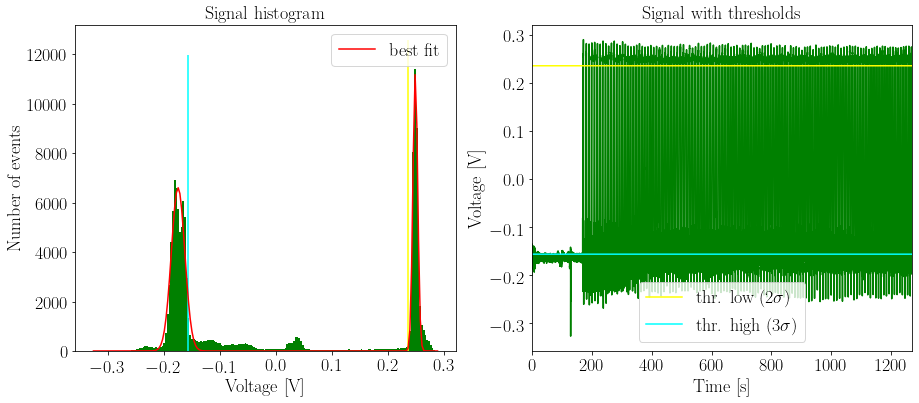

In [21]:
thr_low_2, thr_high_2, sigma_low_2, sigma_high_2 = ddt.thr_searcher(sig2_r, 200, low_sigmas=2, high_sigmas=3, Xdata=t,
                                         color='green', xlabel='Time [s]', ylabel='Voltage [V]')

## Drops detection

### Signal 1

123 123
123 123


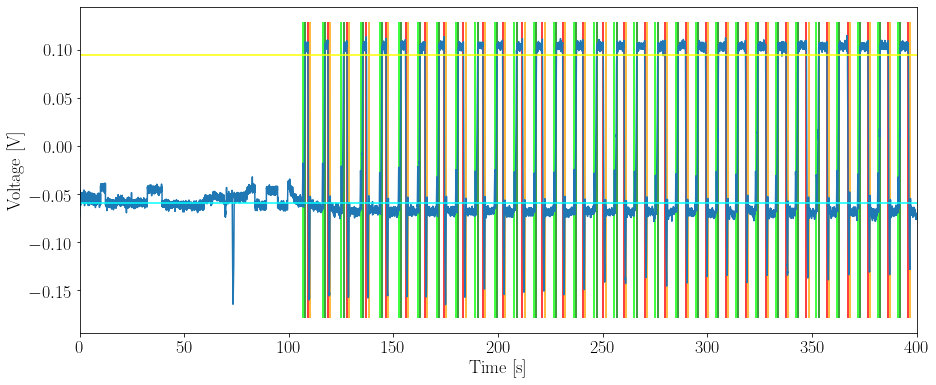

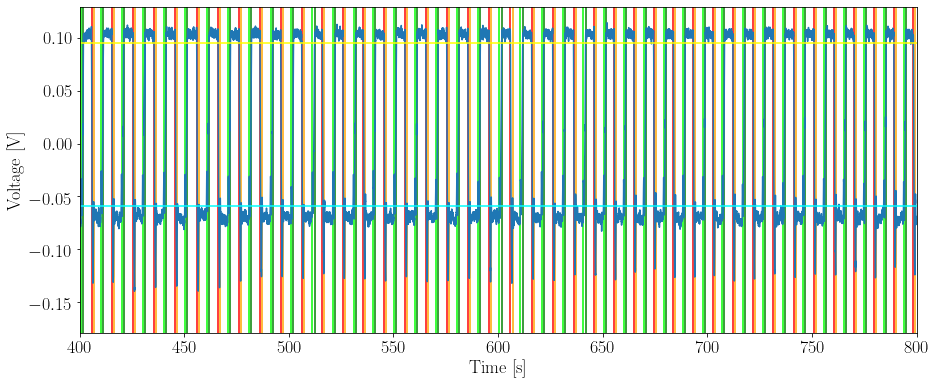

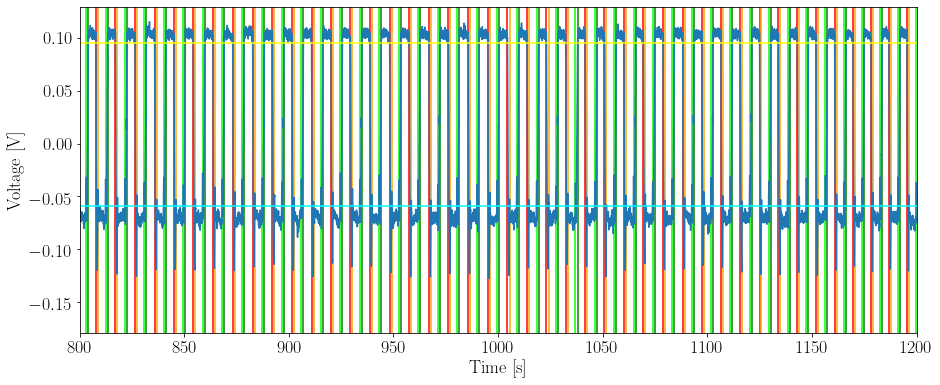

In [22]:
#****************************************
xrange = 400 # single plot x range [s]
#****************************************

%matplotlib inline
returns = ddt.drop_det_new(t, sig1_r, thr_low_1, thr_high_1, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True, xlabel="Time [s]", ylabel="Voltage [V]")

narrow_start_1, narrow_end_1, wide_start_1, wide_end_1 = returns
#function modified to give output arrays in index form, not in seconds.

# global narrow_start_1
# global narrow_end_1
# global wide_start_1
# global wide_end_1

### Signal 2

117 117
117 117


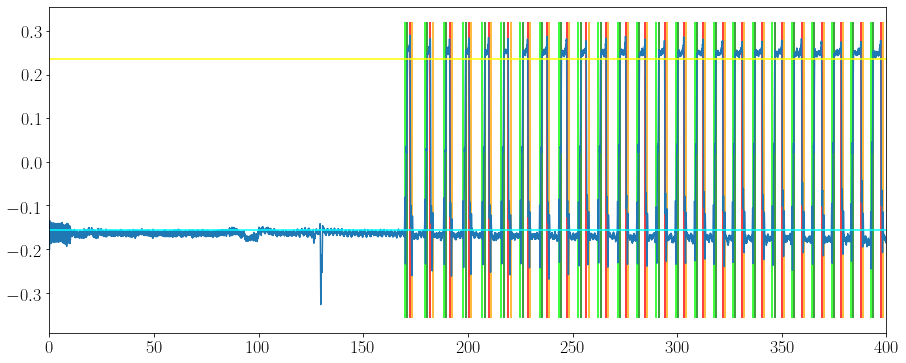

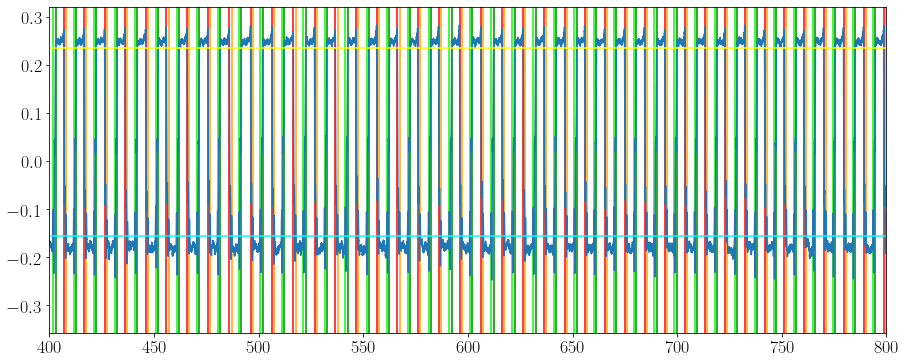

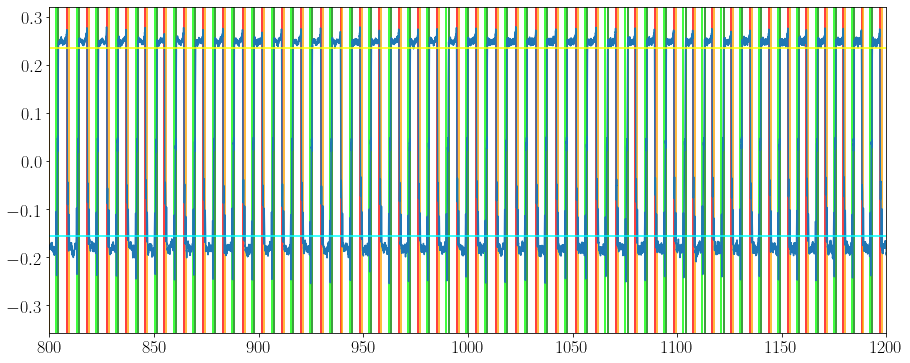

In [23]:
#****************************************
xrange = 400 # single plot x range [s]
#****************************************

%matplotlib inline
returns = ddt.drop_det_new(t, sig2_r, thr_low_2, thr_high_2, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True)

narrow_start_2, narrow_end_2, wide_start_2, wide_end_2 = returns
#function modified to give output arrays in index form, not in seconds.
global narrow_start_2
global narrow_end_2
global wide_start_2
global wide_end_2

## Add errors

In [24]:
def slopes(Xdata, Ydata, start_idxs, end_idxs, start_range, end_range, plot_switch=True):

    def lin_func(x,a,b):
        return a*x + b
    
    slope_start = []
    slope_end   = []
    
    if plot_switch:
        fig, ax = plt.subplots(figsize=(13,6))
        ax.plot(Xdata,Ydata, color='blue', alpha = 0.5)
    
    for n_start, n_end in list(zip(start_idxs,end_idxs)):
        x = Xdata[n_start-start_range:n_start+start_range]
        y = Ydata[n_start-start_range:n_start+start_range]
        popt, pcov = optim.curve_fit(lin_func, x, y)
        slope_start.append(popt[0])
        #example plot
        if plot_switch:
            fit_curve = lin_func(x,*popt)
            ax.plot(x, fit_curve, color='green')

        x = Xdata[n_end-end_range:n_end+end_range]
        y = Ydata[n_end-end_range:n_end+end_range]
        popt, pcov = optim.curve_fit(lin_func, x, y)
        slope_end.append(popt[0])
        
        if plot_switch:
            fit_curve = lin_func(x,*popt)
            ax.plot(x, fit_curve, color='red')

            
    return np.array(slope_start), np.array(slope_end)

False

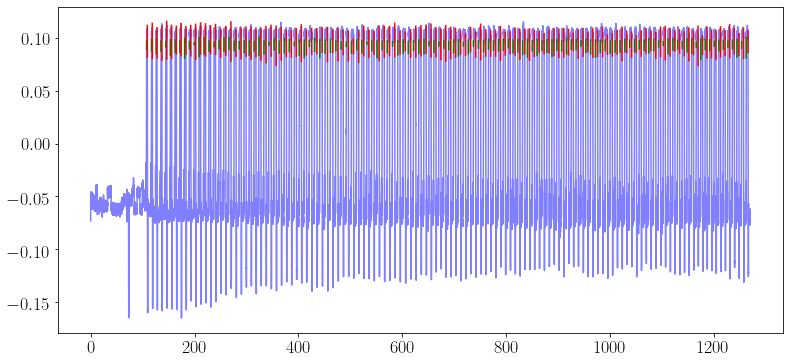

In [25]:
slope_start_1, slope_end_1=slopes(t,sig1_r, narrow_start_1, narrow_end_1, start_range=3, end_range = 5)

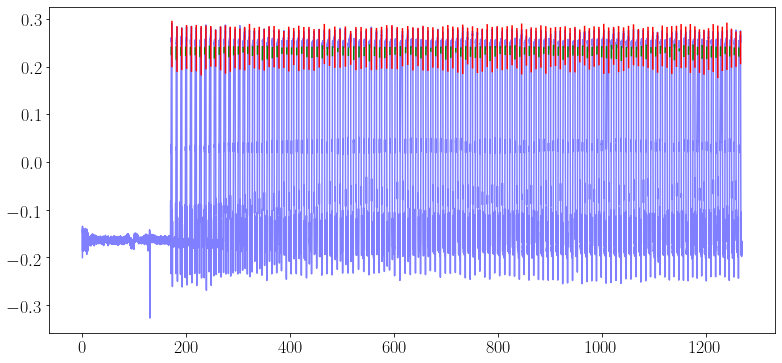

In [26]:
slope_start_2, slope_end_2=slopes(t,sig2_r, narrow_start_2, narrow_end_2, start_range=3, end_range = 5)

In [27]:
#slope errors for narrow_start and narrow_end
v_err_1 = sigma_high_1
err_slope_start_1 = v_err_1/slope_start_1
err_slope_end_1 = -v_err_1/slope_end_1

v_err_2 = sigma_high_2
err_slope_start_2 = v_err_2/slope_start_2
err_slope_end_2 = -v_err_2/slope_end_2


In [28]:
def res_error(time):
    a = t_raw[np.where(t_raw >= time)]
    
    return (a[1] - a[0])/np.sqrt(12)
#     return a[1] - a[0]

### Make ufloats

In [55]:
#error resolution + error slope (seconds)
err_n_start_1=[]
err_n_end_1=[]
err_w_start_1=[]
err_w_end_1=[]
err_n_start_2=[]
err_n_end_2=[]
err_w_start_2=[]
err_w_end_2=[]

drop_edges_1 = [err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1]
drop_edges_2 = [err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2]

for drop_idx in range(len(narrow_start_1)):
    ens1 = (np.sqrt(res_error(t[narrow_start_1[drop_idx]])**2 + err_slope_start_1[drop_idx]**2))
    ene1 = (np.sqrt(res_error(t[narrow_end_1[drop_idx]])**2 + err_slope_end_1[drop_idx]**2))
    ews1 = (res_error(t[wide_start_1[drop_idx]]))
    ewe1 = (res_error(t[wide_end_1[drop_idx]]))
    
    err_n_start_1.append(unc.ufloat(t[narrow_start_1[drop_idx]],ens1))
    err_n_end_1.append(unc.ufloat(t[narrow_end_1[drop_idx]],ene1))
    err_w_start_1.append(unc.ufloat(t[wide_start_1[drop_idx]],ews1))
    err_w_end_1.append(unc.ufloat(t[wide_end_1[drop_idx]],ewe1))

for drop_idx in range(len(narrow_start_2)):
    ens2 = (np.sqrt(res_error(t[narrow_start_2[drop_idx]])**2 + err_slope_start_2[drop_idx]**2))
    ene2 = (np.sqrt(res_error(t[narrow_end_2[drop_idx]])**2 + err_slope_end_2[drop_idx]**2))
    ews2 = (res_error(t[wide_start_2[drop_idx]]))
    ewe2 = (res_error(t[wide_end_2[drop_idx]]))
    
    err_n_start_2.append(unc.ufloat(t[narrow_start_2[drop_idx]],ens2))
    err_n_end_2.append(unc.ufloat(t[narrow_end_2[drop_idx]],ene2))
    err_w_start_2.append(unc.ufloat(t[wide_start_2[drop_idx]],ews2))
    err_w_end_2.append(unc.ufloat(t[wide_end_2[drop_idx]],ewe2))
    

drop_edges_1 = [np.array(e) for e in drop_edges_1]
drop_edges_2 = [np.array(e) for e in drop_edges_2]

err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2

to_adjust = True

## Delay and everything that goes with it

In [39]:
# spannometric estimation of the time interval between the drops, knowing the pumps fluxes and capillary size

#********************************************************
radius  = 0.3  # capillary radius [mm]
sep     = 50   # spearation between the two sensors [mm]
flux_ol = 2    # oil flux   [uL/min] = [mm3/min]
flux_aq = 2    # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]
dt = sep/v                      # time interval between two following drops [s]

print('v  = ', v,'\t[mm/s] \ndt = ', dt, '\t[s]')

v  =  0.9431404035075279 	[mm/s] 
dt =  53.014376029327764 	[s]


In [66]:
#this function calculates delay between sig1 and sig2 by spectra smoothing (delay_gauss) 
#and by simple spectra subtraction (delay_spectra)
    
def delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time, vec1, vec2, signal1, signal2,
          min_cut_idx=0, max_cut_idx=5000):   
    
    
    # Gaussian formula ---------------------------------------

    q = np.sqrt(2*np.pi)
    def gaus(x, mu, sigma):
        return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

    
    # Gaussian smoothing functions ---------------------------

    # Signal 1
    @np.vectorize
    def sig1_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec1:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s
    
    # Signal 2
    @np.vectorize
    def sig2_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec2:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s


    # Delay computing ::::::::::::::::::::::::::::::::::::::::::::
    
    start_delay = dt - delta_delay                                # initial evaluated delay [s]
    stop_delay  = dt + delta_delay                                # final evaluated delay [s]
    time_delays = np.arange(start_delay, stop_delay, step_delay)  # vector of evaluated delays [s]
    ts          = np.arange(start_time,  stop_time,  step_time)   # vector of scanned times [s]
    msqs        = []                                              # stdev between sig.1 and sig.2 delayed 

    
    # Computing delay_gauss --------------------------------------
    
    for time_delay in tqdm(time_delays):

        sig1_t = sig1_smooth(ts, sigma, delta)
        sig2_t = sig2_smooth(ts + time_delay, sigma, delta)
        msqs.append(np.mean((sig2_t - sig1_t)**2))

    msqs=np.array(msqs)
    delay_gauss=time_delays[msqs==min(msqs)]
    
    
    # Delay with spectra-subtraction -----------------------------
    
    delay_idxs = np.arange(int(start_delay*100), int(stop_delay*100))
    msqs1 = []

    for idx in delay_idxs:
            #sig1_cut = sig1_high[:len(sig2_high) - idx][start_time*100:stop_time*100]
            #sig2_cut = sig2_high[idx:][start_time*100:stop_time*100]
            sig1_cut = signal1[:len(signal2) - idx][min_cut_idx:max_cut_idx]
            sig2_cut = signal2[idx:][min_cut_idx:max_cut_idx]
            msqs1.append(np.mean((sig1_cut - sig2_cut)**2))
    msqs1=np.array(msqs1)
    delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]] 
   

    # Plots ------------------------------------------------------
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))    
    ax[0].set_title('Delay spectrum from gaussian broadening')
    ax[0].set_xlabel("delay [s]")
    ax[0].set_ylabel("msqs")
    ax[0].plot(time_delays,msqs)
    ax[1].set_title('Delay spectrum from signal subtraction')
    ax[1].set_xlabel("Delay [s]")
    ax[1].set_ylabel("msqs")
    ax[1].set_xlim(*ax[0].get_xlim())
    ax[1].plot(t[delay_idxs],msqs1)
    fig.tight_layout()
    
    #define the number of initial drops to be neglected in sig2 
    neglected_drops_2 = vec2[vec2<delay_spectra]
    d2 = len(neglected_drops_2)    
          
    return delay_gauss, delay_spectra, d2

100%|██████████| 800/800 [00:15<00:00, 51.10it/s]
<ipython-input-66-b2ea4181de10>:73: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]]


<IPython.core.display.Javascript object>


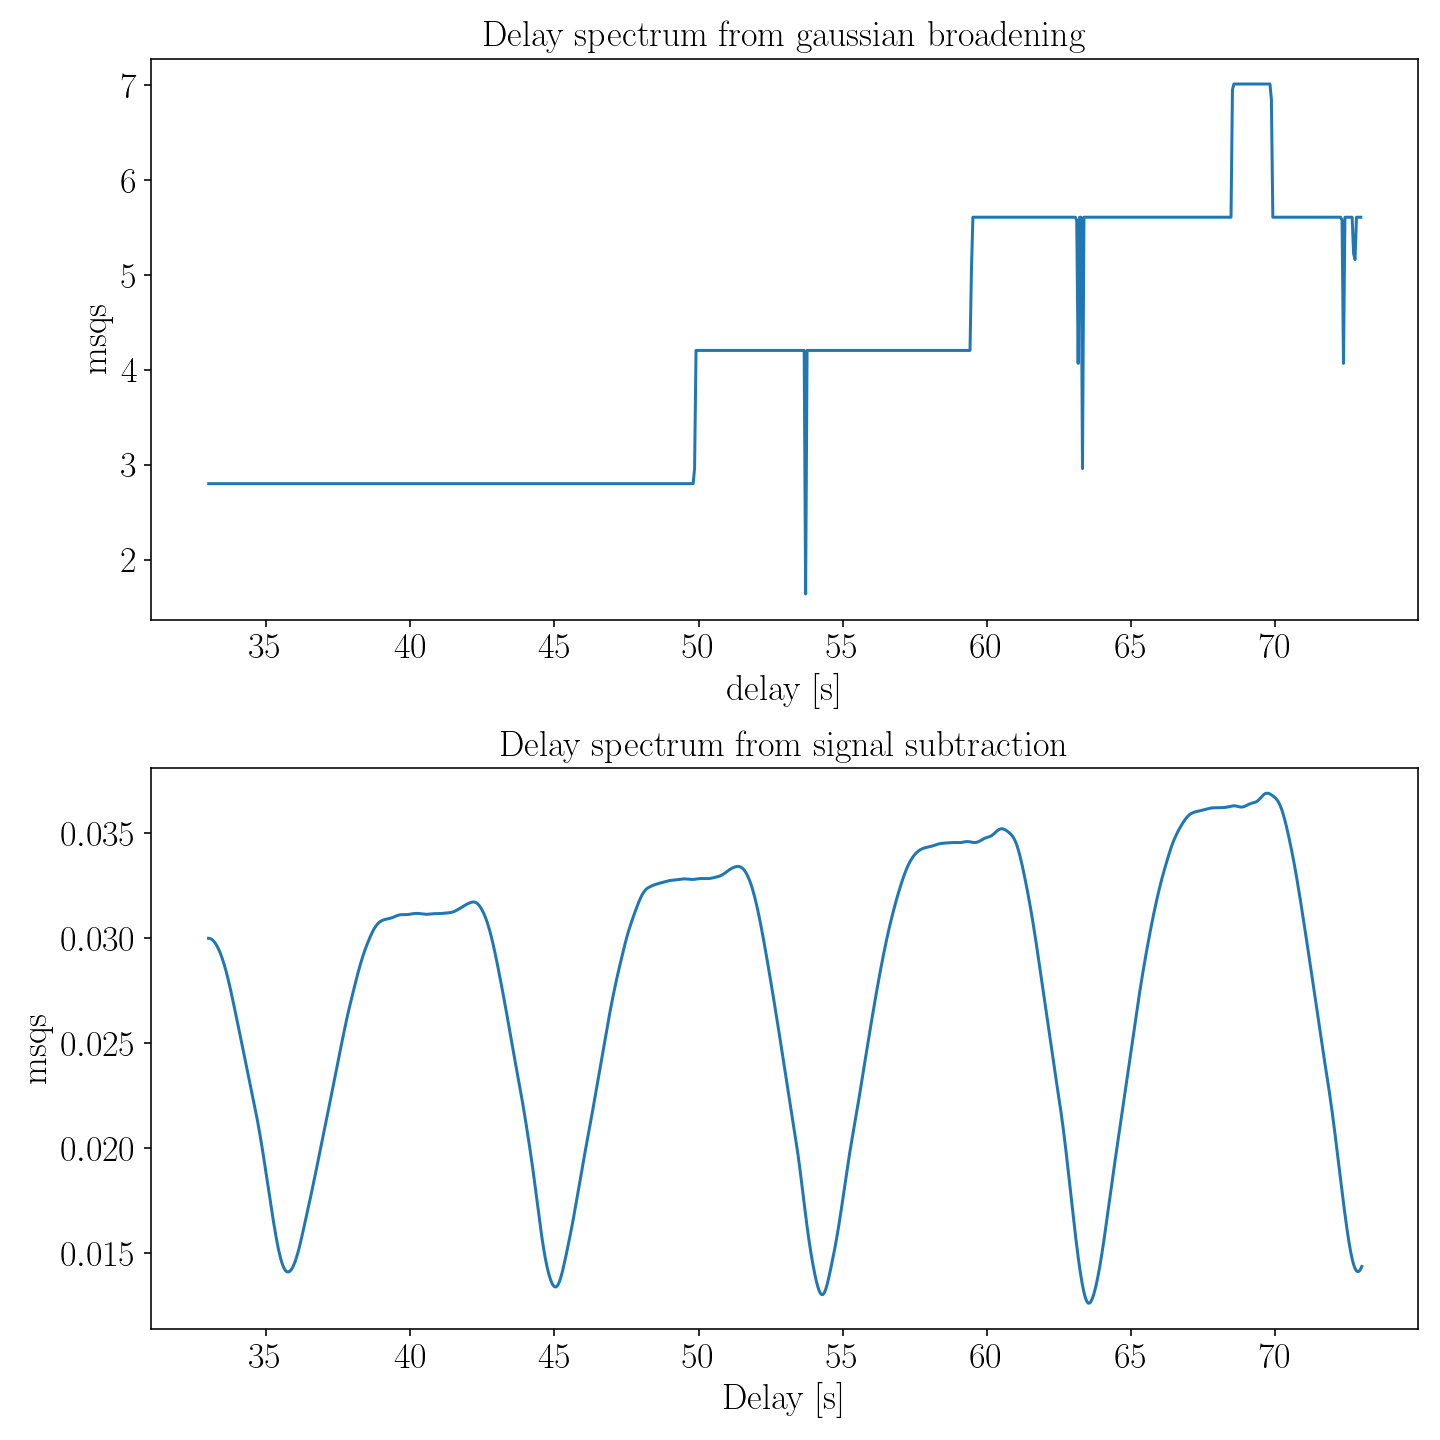

(array([53.71437603]), array([63.54]), 0)

In [94]:
#*********************************************************************************************
# Signal gaussian smoothing
sigma       = 0.01   # stdev
delta       = 2      # range = delta*stdev
# Delay
delta_delay = 20      # range of evaluated delays = [dt - delta_delay ; dt + delta_delay] [s]
step_delay  = 0.05   # step of evaluated delays [s]
# Time
start_time  = 100     # scanning signal starting time [s]
stop_time   = 120     # scanning signal stopping time [s]
step_time   = 0.005  # scanning signal step time [s]

vec1 = np.array([d.n for d in err_w_start_1])
vec2 = np.array([d.n for d in err_w_start_2])

signal1 = sig1_r
signal2 = sig2_r
#*********************************************************************************************

delay_gauss, delay_spectra, d2 = delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time,
                                       vec1, vec2, signal1, signal2,
                                       min_cut_idx=5000, max_cut_idx = 20000)

delay_gauss, delay_spectra, d2

### Manually check the delay

In [78]:
def align(delay):
    
    delay_idx = int(delay*100)
    
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    ax1.plot(t, sig1_r, color='blue', alpha=0.3)
    
    ax2 = ax1.twinx()
    
    ax2.plot(t[:-delay_idx], sig2_r[delay_idx:], color='red', alpha=0.3)
    

In [89]:
reload(plt)

<module 'matplotlib.pyplot' from '/home/alessandro/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<IPython.core.display.Javascript object>


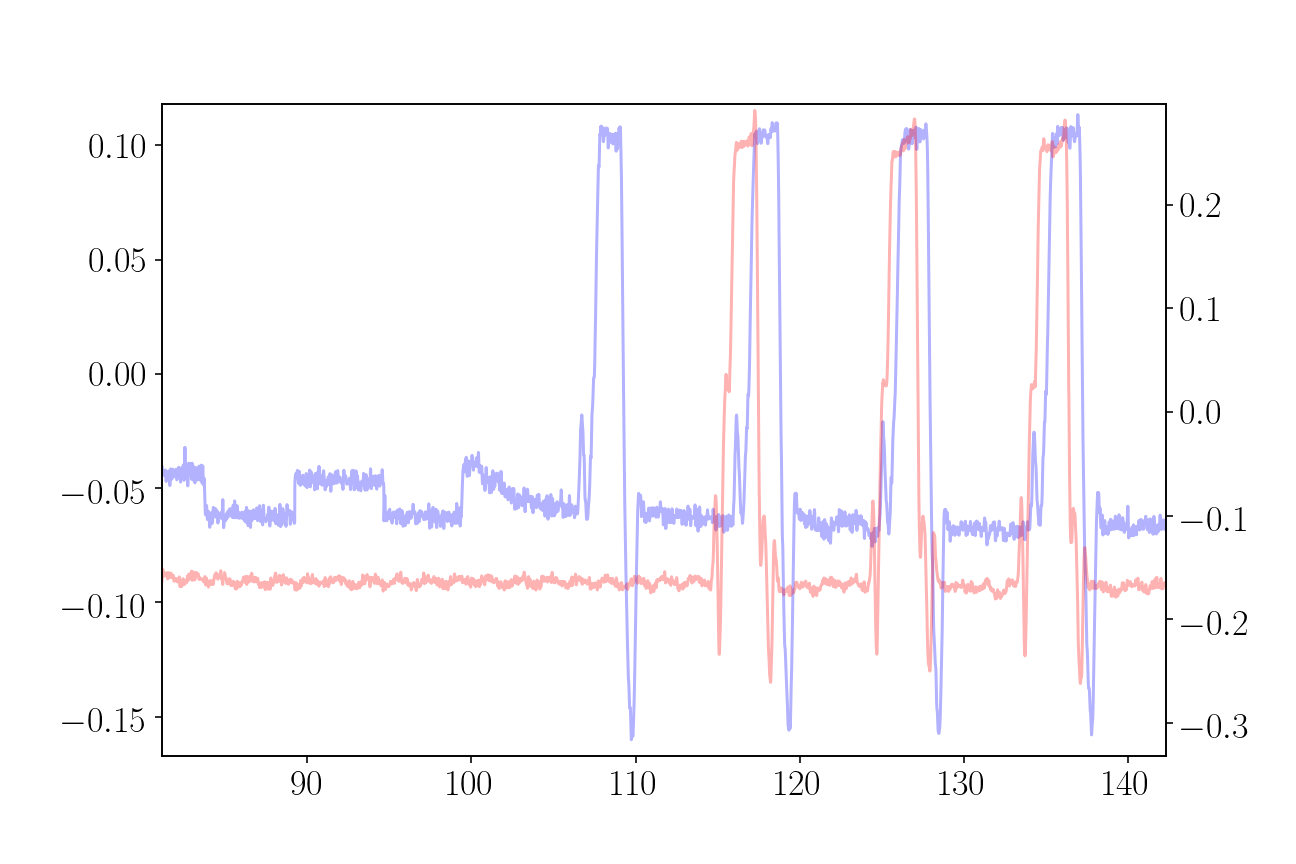

In [92]:
%matplotlib notebook
%matplotlib notebook

align(55)

## Adjust drops according to delay

In [95]:
#decide whether to use calculated d2 or to set it by hand
#d2 = 
def adjust_drops(d1,d2, drop_edges_1, drop_edges_2):
    
    drop_edges_1 = [d[d1:] for d in drop_edges_1]
    drop_edges_2 = [d[d1 + d2:] for d in drop_edges_2]
    
    len2 = len(drop_edges_2[0])
    drop_edges_1 = [d[:len2] for d in drop_edges_1]
    
    return drop_edges_1, drop_edges_2

In [97]:
#THIS FUNCTION MODIFIES drop_start and drop_end s arrays

d1 = 0          #d1>0 to discard some initial drops that are present in both signals
# d2 = 0
if to_adjust:
    drop_edges_1,drop_edges_2 = adjust_drops(d1,d2, drop_edges_1, drop_edges_2)

    err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
    err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2
    
    to_adjust = False

In [98]:
list(zip(*drop_edges_1))

[(106.72+/-0.007505553499468155,
  107.78+/-0.017555581966966338,
  109.11+/-0.01031078033232106,
  110.19+/-0.006928203230275772),
 (116.15+/-0.006928203230275772,
  117.21000000000001+/-0.013391747486906141,
  118.68+/-0.009784624067518403,
  119.78+/-0.007216878364867861),
 (125.07000000000001+/-0.007216878364871964,
  126.13000000000001+/-0.012173878566574725,
  127.78+/-0.01084692625115722,
  128.83+/-0.007505553499468155),
 (134.27+/-0.006928203230275772,
  135.34+/-0.015114098192951238,
  137.08+/-0.010190793789892794,
  138.16+/-0.006928203230275772),
 (143.67000000000002+/-0.007505553499468155,
  144.54+/-0.02700206390491855,
  146.47+/-0.009685193113419024,
  147.57+/-0.007216878364871964),
 (152.52+/-0.00750555349945995,
  153.59+/-0.011491100947101495,
  155.75+/-0.010304152282978716,
  156.83+/-0.007216878364871964),
 (161.61+/-0.006928203230275772,
  162.69+/-0.013169796346491139,
  164.98+/-0.011111334336381905,
  166.08+/-0.00750555349945995),
 (170.75+/-0.0072168783648

In [100]:
drop_edges_1[1]

array([107.78+/-0.017555581966966338,
       117.21000000000001+/-0.013391747486906141,
       126.13000000000001+/-0.012173878566574725,
       135.34+/-0.015114098192951238, 144.54+/-0.02700206390491855,
       153.59+/-0.011491100947101495, 162.69+/-0.013169796346491139,
       171.78+/-0.01326127749490302, 180.93+/-0.009864465190659356,
       190.16+/-0.01967962036075129, 199.47+/-0.07443755761511606,
       208.8+/-0.010021449659351719, 218.32+/-0.010894878880533277,
       227.86+/-0.014671713586170726, 237.44+/-0.030616280048328854,
       247.07+/-0.017370909360975288, 256.67+/-0.012613393694863622,
       266.27+/-0.013312352508343728,
       276.28000000000003+/-0.016098909582464398,
       286.02+/-0.019929735580179943,
       295.59000000000003+/-0.013598176079852944,
       305.3+/-0.011798806220299963, 314.69+/-0.015550152902747381,
       324.1+/-0.010494950106789474, 333.71+/-0.01264915910178655,
       343.25+/-0.042915570968884056, 353.18+/-0.01385890684485691,
     

## Define variables of interest

### Wide

In [32]:
#mid point (in seconds)
wide_mid_1 = 0.5*(t[wide_start_1] + t[wide_end_1])
wide_mid_2 = 0.5*(t[wide_start_2] + t[wide_end_2])

#drops distances in the same channel
wide_distance_1 = t[wide_start_1][1:] - t[wide_end_1][:-1]
wide_distance_2 = t[wide_start_2][1:] - t[wide_end_2][:-1]

#temporal size
wide_size_1 = t[wide_end_1] - t[wide_start_1]
wide_size_1 = t[wide_end_2] - t[wide_start_2]

dt_mid = wide_mid_2 - wide_mid_1
v_mid = 50/dt_mid

## Errors

In [35]:
# calculate slope around narrow_start and narrow_end
def slopes(Xdata, Ydata, narrow_start, narrow_end, start_range, end_range):

    def lin_func(x,a,b):
        return a*x + b
    
    slope_start = []
    slope_end   = []
    
    fig, ax = plt.subplots(figsize=(13,6))
    ax.plot(Xdata,Ydata, color='blue', alpha = 0.5)
    
    for n_start, n_end in list(zip(narrow_start,narrow_end)):
        x = Xdata[n_start-start_range:n_start+start_range]
        y = Ydata[n_start-start_range:n_start+start_range]
        popt, pcov = optim.curve_fit(lin_func, x, y)
        slope_start.append(popt[0])
        #example plot

        fit_curve = lin_func(x,*popt)
        ax.plot(x, fit_curve, color='green')

        x = Xdata[n_end-end_range:n_end+end_range]
        y = Ydata[n_end-end_range:n_end+end_range]
        popt, pcov = optim.curve_fit(lin_func, x, y)
        slope_end.append(popt[0])
        
        fit_curve = lin_func(x,*popt)
        ax.plot(x, fit_curve, color='red')

            
    return np.array(slope_start), np.array(slope_end)


# PLOTTING

## Temporal distance between drops in the same signal 

In [ ]:
def time_dist(bins, distances):

    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    ax_joint.plot(distances[:,0],distances[:,1], label='sig1')
    ax_joint.plot(distances[:,0],distances[:,2], color='green', label='sig2')
    h1=ax_marg_y_1.hist(distances[:,1],orientation="horizontal",bins=bins)
    h2=ax_marg_y_2.hist(distances[:,2],orientation="horizontal", color='green',bins=bins)

    # Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('distances [s]')

    #Legend
    ax_joint.legend(loc='best')
    plt.title('Temporal distance between drops in the same signal, as a function of drop id number',loc='right', pad=15)

    #histogram fit
    b1 = h1[1]
    f1 = h1[0]
    x1 = 0.5 *(b1[:-1] + b1[1:])
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')

    b2 = h2[1]
    f2 = h2[0]
    x2 = 0.5 *(b2[:-1] + b2[1:])
    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')
    
    fig.tight_layout()
    plt.show()

    dist1 = out1.best_values.get('g1_center')
    sigma_dist1 = out1.best_values.get('g1_sigma')

    dist2 = out2.best_values.get('g2_center')
    sigma_dist2 = out2.best_values.get('g2_sigma')

    return fig, dist1, sigma_dist1, dist2, sigma_dist2

In [ ]:
#*************
subname = ''
bins    = 12
#*************

fig, dist1, sigma_dist1, dist2, sigma_dist2 = time_dist(bins, distances)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Temporal size 

In [ ]:
def time_size(bins, sizes):

    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    ax_joint.plot(sizes[:,0],sizes[:,1], label='sig1')
    ax_joint.plot(sizes[:,0],sizes[:,2], color='green', label='sig2')
    h1=ax_marg_y_1.hist(sizes[:,1],orientation="horizontal",bins=bins)
    h2=ax_marg_y_2.hist(sizes[:,2],orientation="horizontal", color='green',bins=bins)

    # Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('distances [s]')

    ax_joint.legend(loc='best')
    plt.title('Temporal size of drops in each signal, as a function of drop id number',loc='right', pad=15)

    #histogram fit
    b1 = h1[1]
    f1 = h1[0]
    x1 = 0.5 *(b1[:-1] + b1[1:])
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')

    b2 = h2[1]
    f2 = h2[0]
    x2 = 0.5 *(b2[:-1] + b2[1:])
    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')
    
    fig.tight_layout()
    plt.show()

    t_size1 = out1.best_values.get('g1_center')
    sigma_t_size1 = out1.best_values.get('g1_sigma')

    t_size2 = out2.best_values.get('g2_center')
    sigma_t_size2 = out2.best_values.get('g2_sigma')
    
    return fig, t_size1, sigma_t_size1, t_size2, sigma_t_size2 


In [ ]:
#*************
subname = ''
bins    = 13
#*************

fig, t_size1, sigma_t_size1, t_size2, sigma_t_size2 = time_size(bins, sizes)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Time separation between detectors and drop velocity

In [ ]:
def dt_vel(bins,dt_mid,v_mid):
    
    fig = plt.figure(figsize=(10,7.5))

    gs = GridSpec(8,4)
    #first plot
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])

    ax_joint.plot(dt_mid, label='time interval')
    ax_marg_y.hist(dt_mid,orientation="horizontal", bins=bins)

    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('detectors time interval [s]')

    plt.title('Temporal delay of drops in the detectors and drop velocity',loc='right', pad=15)

    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    #second plot
    ax1_joint = fig.add_subplot(gs[5:8,0:3])
    ax1_marg_y = fig.add_subplot(gs[5:8,3])

    ax1_joint.plot(drop_mid_1,v_mid, label='velocity')
    ax1_marg_y.hist(v_mid,orientation="horizontal", bins=bins)

    ax1_joint.set_xlabel('time (drop equidistant from detectors) [s]')
    ax1_joint.set_ylabel('drops velocity [mm/s]')

    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)


    # Set labels on marginals
    #ax_marg_x.set_ylabel('Marginal y label')
    #Legend
    #ax_joint.legend(loc='best')
    
    fig.tight_layout()
    
    plt.show()

    return fig

In [ ]:
#************
subname = ''
bins    = 10
#************

fig = dt_vel(bins, dt_mid, v_mid)

# fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Spatial size

In [ ]:
def space_size(bins, sizes, vel_mid):
    
    fig = plt.figure(figsize=(10,7))
    gs = GridSpec(4,5)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[1:4,3])
    ax_marg_y_2 = fig.add_subplot(gs[1:4,4])

    ax_joint.plot(sizes[:,1]*vel_mid, label='sig1')
    ax_joint.plot(sizes[:,2]*vel_mid, color='green', label='sig2')
    h1=ax_marg_y_1.hist(sizes[:,1]*vel_mid,orientation="horizontal",bins=bins)
    h2=ax_marg_y_2.hist(sizes[:,2]*vel_mid,orientation="horizontal", color='green',bins=bins)

    # Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('size [mm]')

    ax_joint.legend(loc='best')
    plt.title('Spatial size of drops in each signal, as a function of drop id number',loc='right', pad=15)

    #histogram fit
    b1 = h1[1]
    f1 = h1[0]
    x1 = 0.5 *(b1[:-1] + b1[1:])
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
    out1 = mod1.fit(f1, pars1, x=x1)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')

    b2 = h2[1]
    f2 = h2[0]
    x2 = 0.5 *(b2[:-1] + b2[1:])
    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
    #ax_marg_y.legend(loc='best')
    
    #fig.tight_layout()
    
    plt.show()
    
    #parameters from fit
    size1 = out1.best_values.get('g1_center')
    sigma_size1 = out1.best_values.get('g1_sigma')

    size2 = out2.best_values.get('g2_center')
    sigma_size2 = out2.best_values.get('g2_sigma')
    
    return fig, size1, sigma_size1, size2, sigma_size2

In [ ]:
#*****************************
subname = 'spatial_size_test'
bins    = 20
#*****************************

fig, size1, sigma_size1, size2, sigma_size2  = space_size(bins, sizes, v_mid)

#fig.savefig(f'{plot_dir}/{name}_{subname}.png')

## Save fit parameters to file

In [ ]:
fit_filename ='fit-'+filename[:-4]+'.txt'
with open(fit_filename, mode='w', newline ='') as file:
    writer = csv.writer(file, delimiter='	', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    s = ['file containing center1, sigma1, center2, sigma2 from fit']
    writer.writerow(s)
    a = ['spatial size (mm)',size1, sigma_size1, size2, sigma_size2]
    writer.writerow(a)
    b = ['temporal size (s)',t_size1, sigma_t_size1, t_size2, sigma_t_size2]
    writer.writerow(b)
    c = ['temporal distance (mm)',dist1, sigma_dist1, dist2, sigma_dist2]
    writer.writerow(c)
    